# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [486]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [487]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [488]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix
spacy.cli.download("en_core_web_sm")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [489]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [490]:
# define a function to load json file to a dataframe
def funcDataFrameRead(path):
    df=pd.read_json(path)
    return df

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [491]:
# read the json file by giving the file path and create a dataframe
path="ingredient_and_quantity.json"
df=funcDataFrameRead(path)


##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [492]:
# display first five rows of the dataframe - df
df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [493]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [494]:
# print the information of the dataframe
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


In [495]:
duplicates = df[df.duplicated()]


In [496]:
duplicates

Empty DataFrame
Columns: [input, pos]
Index: []

#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [497]:
# split the input and pos into input_tokens and pos_tokens in the dataframe
###Done already by pd.read_json
# Tokenize input

import nltk
nltk.download("punkt_tab")
nltk.download("averaged_perceptron_tagger_eng")
nltk.download("averaged_perceptron_tagger")

from nltk.tokenize import word_tokenize
def func(inp):
    return(word_tokenize(inp))
df['input_tokens']=df['input'].apply(func)
df['pos_tokens']=df['pos'].apply(func)

'''
def funcsplit(inp):
    return([inp.split(" ")])
df['input_tokens']=df['input'].apply(func)
df['pos_tokens']=df['pos'].apply(func)
'''

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


'\ndef funcsplit(inp):\n    return([inp.split(" ")])\ndf[\'input_tokens\']=df[\'input\'].apply(func)\ndf[\'pos_tokens\']=df[\'pos\'].apply(func)\n'

In [498]:
# display first five rows of the dataframe - df
df.head(5)

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablespoon, oil, asafoetida]                               

In [499]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   input         285 non-null    object
 1   pos           285 non-null    object
 2   input_tokens  285 non-null    object
 3   pos_tokens    285 non-null    object
dtypes: object(4)
memory usage: 9.0+ KB


##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [500]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
def countlen(data):
    return(len(data))
df['input_token_length']=df['input_tokens'].apply(countlen)
df['pos_token_length']=df['pos_tokens'].apply(countlen)


In [501]:
# check for the equality of input_length and pos_length in the dataframe
df[df['input_token_length'] != df['pos_token_length']].pos.count()



np.int64(28)

**Found 28 rows with unequal pos and input data**

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [502]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_labels(data):    
    return list(set(sorted(data.split(" "))))
df['unique_labels']=df['pos'].apply(unique_labels)

##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe


In [503]:
df.isnull().sum()

####There are no columns with ZERO values

input                 0
pos                   0
input_tokens          0
pos_tokens            0
input_token_length    0
pos_token_length      0
unique_labels         0
dtype: int64

<font color = red>[write your answer]</font> <br>
There are 28 rows where the pos token count doesnt match with input token. 

##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [504]:
# drop the irrelevant recipe data
old_df = df.copy()


In [505]:
df=df[~(df['input_token_length'] != df['pos_token_length'])]

df = df[~df.apply(lambda row: row.astype(str).str.contains("-", regex=False).any(), axis=1)]


In [506]:
print(df.shape)
print(old_df.shape)




(209, 7)
(285, 7)


**Cleanup of 28 rows done above**

##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [507]:
df['input_token_length']=df['input_tokens'].apply(countlen)
df['pos_token_length']=df['pos_tokens'].apply(countlen)

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [508]:
# validate the input length and pos length as input_length and pos_length
df[df['input_token_length'] != df['pos_token_length']].pos.count()

print("Found 0 rows with uneuqual pos_token and input_token.")

Found 0 rows with uneuqual pos_token and input_token.


In [509]:
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_token_length  pos_token_length                 unique_labels
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]                  31                31  [quantity, ingredient, unit]
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient  [500, grams, Chicken, 2, Onion, chopped, 1, Tomato, 4, Green, Chillies, slit, inch, Ginger, finely, 6, cloves, Garlic, 1/2, teaspoon, Turmeric, powder, Haldi, Garam, masala, tablespoon, Sesame, Gingelly, Oil, 1/4, Methi, Seeds, 

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [510]:
# split the dataset into training and validation sets
from sklearn.model_selection import train_test_split
train_df,val_df=train_test_split(df[['input','pos']],train_size=0.7,random_state=42,)
train_df_all,val_df_all=train_test_split(df[['input','pos','input_tokens','pos_tokens']],train_size=0.7,random_state=42,)

#X_train, X_val, y_train, y_val = train_test_split(df['input_tokens'], df['pos_tokens'], test_size=0.3, random_state=42)

print(len(train_df))
print(len(val_df))

146
63


###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [511]:
# print the first five rows of train_df

train_df.columns=['input','pos']
val_df.columns=['input','pos']

train_df_all.columns = ['input','pos','input_tokens','pos_tokens']
val_df_all.columns=['input','pos','input_tokens','pos_tokens']

In [512]:
# print the first five rows of the val_df
print(val_df.head(5))

                                                                                                                                                                                                                                                                                                         input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 pos
38                                                1 cup jackfruit seeds tamarind water 8 cloves garlic 1/2 teaspoon mustard cumin curry leaves 1/4 turmeric powder red chilli 2 teaspoons sambar asafoetida coriander sunflower oil f

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [513]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train= train_df['input']
X_val = val_df['input']
y_train = train_df['pos']
y_val=val_df['pos']



In [514]:
# validate the shape of training and validation samples
print("X_train -" , X_train.shape)
print("X_val -" , X_val.shape)
print("y_train -" , y_train.shape)
print("y_val -" , y_val.shape)


X_train - (146,)
X_val - (63,)
y_train - (146,)
y_val - (63,)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [515]:
new=[]
[new.append(x) for item in y_train.tolist() for x in list(item.split(" "))]
print(set(sorted(new)))    


{'quantity', 'ingredient', 'unit'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [516]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def flatten_list(nested_list):
    flat = [item for sublist in nested_list for item in sublist]
    #print(flat)
    return(flat)
    


In [517]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [518]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens
def extract_and_validate_tokens(df,dataset_name):
    if dataset_name == 'Training':
        input_token_flat=flatten_list(df['input_tokens'])
        pos_token_flat=flatten_list(df['pos_tokens'])
        print("Length of Train input token:" , len(input_token_flat) )
        print("Length of Train pos token:" , len(pos_token_flat) )
        print("Unique", set(pos_token_flat))
        input_series = pd.Series(input_token_flat).value_counts()
        pos_series = pd.Series(pos_token_flat).value_counts()
        print("\nTop 10 records for Train input tokens :\n",input_series.head(10))
        print("\nTop 10 records for Train pos tokens\n", pos_series.head(10))
    else:
        input_token_flat=flatten_list(df['input_tokens'])
        pos_token_flat=flatten_list(df['pos_tokens'])
        print("Length of Val input token:" , len(input_token_flat) )
        print("Length of Val pos token:" , len(pos_token_flat) )
        input_series = pd.Series(input_token_flat).value_counts()
        pos_series = pd.Series(pos_token_flat).value_counts()
        print("\nTop 10 records for Val input tokens :\n",input_series.head(10))
        print("\nTop 10 records for Val pos tokens\n", pos_series.head(10))
    return(input_token_flat,pos_token_flat)

In [519]:
# extract the tokens and its pos tags
input_token_flat=[]
pos_token_flat=[]

input_token_train,pos_token_train=extract_and_validate_tokens(train_df_all,'Training')
input_token_val,pos_token_val=extract_and_validate_tokens(val_df_all,'Validation')


Length of Train input token: 4926
Length of Train pos token: 4926
Unique {'quantity', 'ingredient', 'unit'}

Top 10 records for Train input tokens :
 1           141
2           118
teaspoon    115
1/2          98
cup          97
powder       96
1/4          78
Salt         72
seeds        69
Oil          67
Name: count, dtype: int64

Top 10 records for Train pos tokens
 ingredient    3655
quantity       688
unit           583
Name: count, dtype: int64
Length of Val input token: 2072
Length of Val pos token: 2072

Top 10 records for Val input tokens :
 1             60
1/2           48
teaspoon      45
cup           44
2             42
powder        39
tablespoon    32
Salt          32
1/4           30
seeds         26
Name: count, dtype: int64

Top 10 records for Val pos tokens
 ingredient    1533
quantity       291
unit           248
Name: count, dtype: int64


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [520]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
quantity=[]
unit=[]
ingredient = []
def categorize_tokens(input_token,pos_token):
    for item, category in zip(input_token, pos_token):
        if category == 'ingredient':
            ingredient.append(item)
        elif category == 'unit':
            unit.append(item)
        elif category == 'quantity':
            quantity.append(item)
        else:
            print(item, "--" , category)
                  
    
        

In [521]:
#  call the function to categorise the labels into respective list
categorize_tokens(input_token_train,pos_token_train)

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [522]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
def get_top_frequent_items(item_list):
    counts = Counter(item_list)
    top_10 = counts.most_common(10)
     
    for item, count in top_10:
        if count > 1:
            print(f"{item}: {count}")
    print("\n")
    return(top_10)
    

In [523]:
# get the top ingredients which are frequently seen in the recipe
top10_ingredient=get_top_frequent_items(ingredient)

powder: 96
Salt: 72
seeds: 69
Oil: 67
chopped: 65
Red: 58
Green: 58
Chilli: 56
Leaves: 53
Coriander: 51




In [524]:
# get the top units which are frequently seen in the recipe
top10_unit=get_top_frequent_items(unit)

teaspoon: 115
cup: 97
tablespoon: 66
tablespoons: 47
grams: 45
inch: 40
sprig: 36
cups: 36
cloves: 27
teaspoons: 22




#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [525]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
# plotting most frequent words for EDA
def plot_top_items(top_item):
    # Custom colors — must match the number of bars
    plt.figure(figsize=(10, 6))
    palette = sns.color_palette("hls", len(top_item))  
    sns.barplot(data=top_item,x='item',y='count',palette=palette)
    # Plot
    plt.title("Top 10 Most Frequent Items")
    plt.xlabel("Item")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



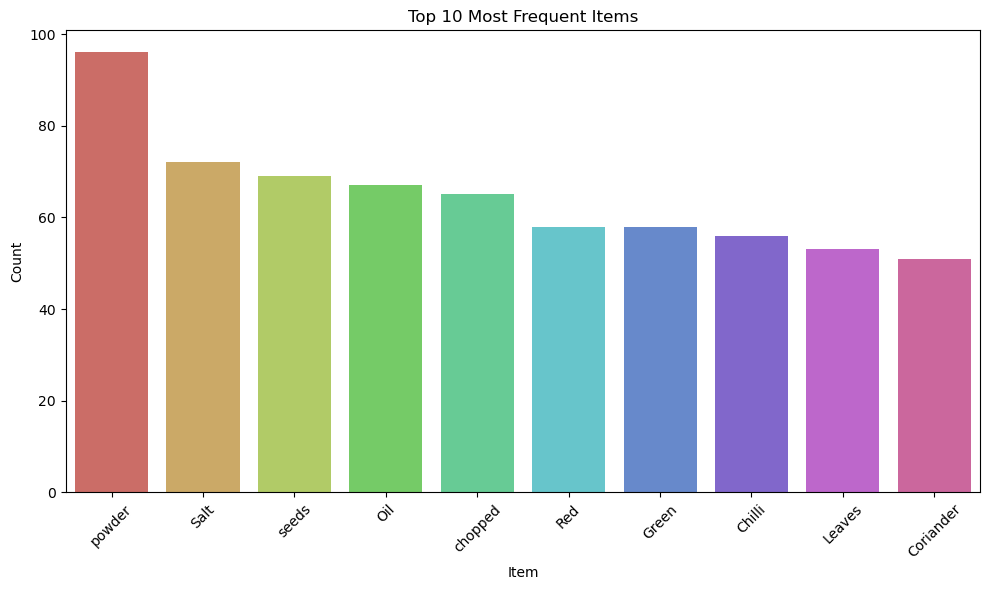

In [526]:
# plot the top frequent ingredients in training data
df_top10_ingredient=pd.DataFrame(top10_ingredient,columns=['item','count'])

plot_top_items(df_top10_ingredient)

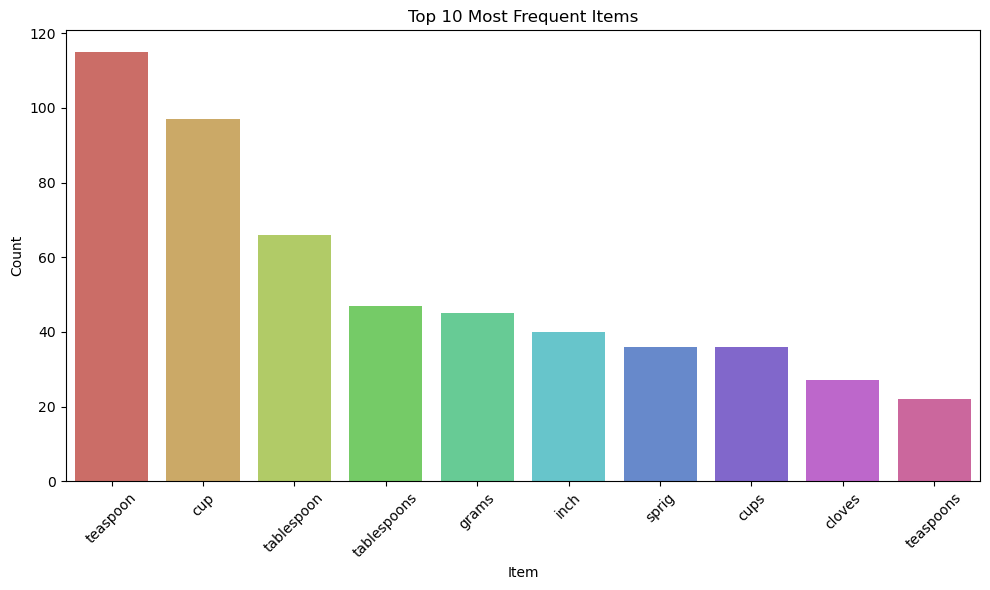

In [527]:
# plot the top frequent units in training data
df_top10_unit=pd.DataFrame(top10_unit,columns=['item','count'])
plot_top_items(df_top10_unit)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [528]:
# initialise the dataset_name
Validation = pd.DataFrame()


In [529]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe
categorize_tokens(input_token_train,pos_token_train)
top10_ingredient=get_top_frequent_items(ingredient)
top10_unit=get_top_frequent_items(unit)

powder: 192
Salt: 144
seeds: 138
Oil: 134
chopped: 130
Red: 116
Green: 116
Chilli: 112
Leaves: 106
Coriander: 102


teaspoon: 230
cup: 194
tablespoon: 132
tablespoons: 94
grams: 90
inch: 80
sprig: 72
cups: 72
cloves: 54
teaspoons: 44




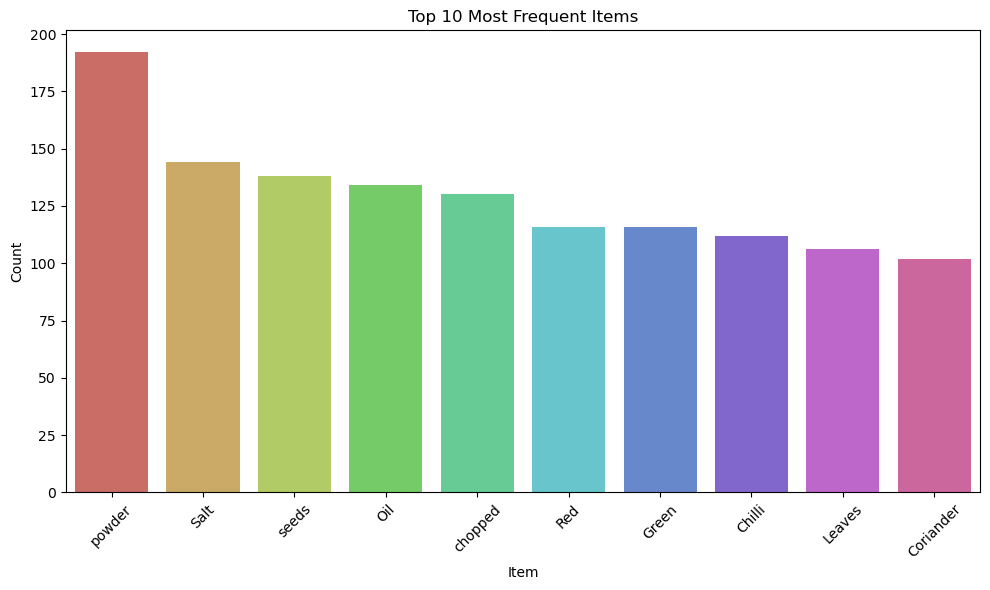

In [530]:
# plot the top frequent ingredients in validation data
df_val_top10_ingredient=pd.DataFrame(top10_ingredient,columns=['item','count'])
plot_top_items(df_val_top10_ingredient)

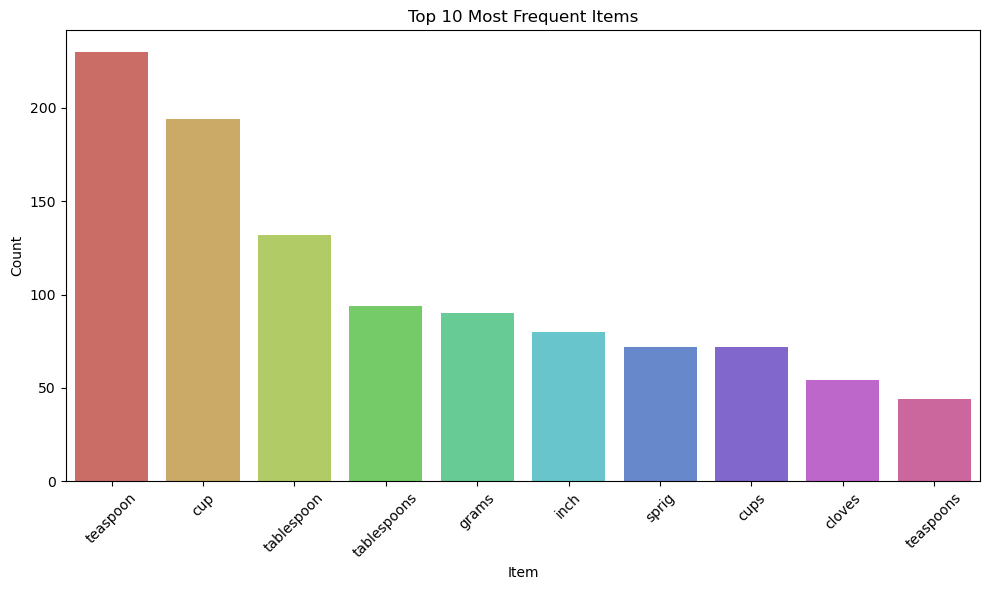

In [531]:
# plot the top frequent units in Validation data
df_val_top10_unit=pd.DataFrame(top10_unit,columns=['item','count'])
plot_top_items(df_val_top10_unit)

## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [532]:
# define unit and quantity keywords along with quantity pattern

unit_keywords=set(sorted(unit))
quantity_keywords=set(sorted(quantity))
quantity_pattern = '([0-9]+|[0-9]+\.[0-9+]|[0-9]+\-[1-9]+|[0-9]+\-[1-9]\/[1-9]+|\+[1-9]+\/[1-9]+|[Ll]ittle||[Pp]er|[Oo]ne|[Tt]wo|[]one|[Ff]ew|[Pp]inch|[1-9]+|[1-9]\/[1-9]+|[1-9]+\-[1-9]\/[1-9]+)'


print("Unit Keyword" , unit_keywords)
print("Quantity Keyword" , quantity_keywords)


Unit Keyword {'tsp', 'pinch', 'tablespoons', 'thick', 'small', 'cloves', 'teaspoons', 'gram', 'Teaspoon', 'cup', 'long', 'Tbsp', 'ml', 'liter', 'sprigs', 'inch', 'raw', 'inches', 'kg', 'tablespoon', 'grams', 'Tablespoon', 'thin', 'Sprig', 'sprig', 'Spoon', 'cups', 'teaspoon', 'tbsp', 'clove'}
Quantity Keyword {'1', '24', '4', 'pinch', '250', '30', '3/4', '12', 'a', '1/4', '10', '300', '8', 'few', '1/8', 'as', '6', 'one', '500', '1.5', '2.5', '200', '5', '400', '150', '100', '2', '15', '75', 'to', '350', '80', '3', 'finely', '1/2', '50', 'little', '1/3', 'taste', '18', '7', 'per', '20', '175', 'for', 'Little'}


In [533]:
# load spaCy model
# Import libraries
import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [534]:
# define word2features for processing each token in the sentence sent by using index i.

def word2features(sentence,pos,word_dict):
# use your own feature functions
    word=sentence[pos]  
    #print(word_dict)
    is_begin=str(True if pos == 0 else False)
    is_end=str(False if pos == (len(sentence)-1) else False)
    # previous word features

    VALID_UNITS = {
    "g", "gram", "grams",
    "kg", "kilogram", "kilograms",
    "oz", "ounce", "ounces",
    "lb", "pound", "pounds",
    "ml", "milliliter", "milliliters",
    "l", "liter", "liters",
    "tsp", "teaspoon", "teaspoons",
    "tbsp", "tablespoon", "tablespoons",
    "cup", "cups",
    "pinch", "clove", "cloves",
    "slice", "slices",
    "can", "cans",
    "package", "packages",
    "stick", "sticks"
    }
    is_unit=str(True if word in VALID_UNITS else False)
###################Decimal########################
    decimal_pattern = '([0-9]+\.[0-9]+)'
    is_decimal=str((True if(re.findall(decimal_pattern,word)) else False))

############## Fraction ################
    fraction_match = '([0-9]+/[0-9]+|[0-9]+\s/[0-9]+/[0-9]+)'
    is_fraction=str((True if(re.findall(fraction_match,word)) else False))

################ Quantity ###########
    matched=re.findall(quantity_pattern,word)
    is_quantity=str((True if matched else False))
############is_numeric################
    numeric_pattern = re.compile(r'^(\d+(\.\d+)?|\d+/\d+)$') 

    def is_numeric():
        return str(bool(numeric_pattern.match(word)))

################# has_digit #############
    has_digit = str(bool(re.search(r'\d', word)))
##################has alpha #####################
    has_alpha = str(bool(re.search(r'[A-Za-z]',word)))
#####################has hyphenated#######
    has_hyphenated = str(bool(re.search(r'\-',word)))
#######################has slash present####################
    has_slash = str(bool(re.search(r'\/',word)))
#### is_begin####################
    if(pos == 0):
        is_begin=str(True)
    else:
        is_begin=str(False)
###########is end############
    if(pos == (len(sentence) - 1)):
        is_end=str(True)
    else:
        is_end=str(False)
########################
    features = [
    # --- Core Features ---
    'word.bias=1.0',
    'word.token=' + word.lower(), 
    'word.lemma=' + word_dict.get('LEMMA'), 
    'word.pos_tag=' + word_dict['POS'],
    'word.dep=' + word_dict['DEP'],
    'word.tag=' + word_dict['TAG'],
    'word.shape=' + word_dict['Shape'],
    'word.is_stop=' + word_dict['is_stop'],
    'word.is_digit=' + word_dict['is_digit'],
    'word.has_digit=' + has_digit,
    'word.has_alpha=' + has_alpha,
    'word.hyphenated=' + has_hyphenated,
    'word.slash_present=' + has_slash,
    'word.is_title=' + word_dict['is_title'],
    'word.is_upper=' + word_dict['is_upper'],
    'word.is_punct=' + word_dict['is_punct'],
    'word.is_quantity=' + is_quantity,
    'word.is_unit=' + is_unit,
    'word.is_numeric=' + is_numeric(),
    'word.is_fraction=' + is_fraction,
    'word.is_decimal=' + is_decimal,
    'word.BOS=' + is_begin,
    'word.EOS=' + is_end   
    ]

    if(pos > 0):
        prev_word = sentence[pos-1]
        matched=re.findall(quantity_pattern,prev_word)
        prev_is_quantity=str((True if matched else False))
        prev_is_digit=str(True if prev_word.isdigit() else False)
        features.extend([
        'word.prev_token=' + prev_word.lower(),
        'word.preceding_word=' + prev_word,
        'word.prev_is_quantity=' + prev_is_quantity,
        'word.prev_is_digit=' + prev_is_digit,
        ])   
        

    if(pos == len(sentence)-1):
        pass
    else:
        following_word=sentence[pos+1]
        next_is_unit=(True if following_word in VALID_UNITS else False)
        matched=re.findall(quantity_pattern,following_word)
        next_is_quantity=(True if matched else False)
        if (~(next_is_quantity) and ~(next_is_unit)):
            next_is_ingredient=str(True)
        else:
            next_is_ingredient=str(False)
        features.extend([
            'word.following_word=' + following_word,
            'word.next_token='+ following_word.lower(),
            'word.next_is_unit=' + str(next_is_unit),
            'word.next_is_ingredient=' + next_is_ingredient,
        ])
        
    #print(features)
    return features



### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [535]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
# Write a code to get features for a sentence.

def sent2features(data):
    full_sentence = data
    doc=nlp(full_sentence)
    data=data.split(" ")
    
        
    for index,word in enumerate(data):
        
        for token in doc:
            word_dict = {}
            if token.text.lower() == word.lower():
                word_dict['Text'] = token.text
                word_dict['POS']=token.pos_
                word_dict['TAG']=token.tag_
                word_dict['LEMMA']=token.lemma_
                word_dict['DEP']=token.dep_
                word_dict['Shape']=token.shape_
                word_dict['is_stop']=str(token.is_stop)
                word_dict['is_digit']=str(token.is_digit)
                #word_dict['has_digit']=token.has_digit
                #word_dict['has_alpha']=token.has_alpha
                #word_dict['hyphenated']=token.hyphenated
                #word_dict['slash_present']=token.slash_present
                word_dict['is_title']=str(token.is_title)
                word_dict['is_upper']=str(token.is_upper)
                word_dict['is_punct']=str(token.is_punct)
            
            #return [word2features(data,index,word_dict) for index,word in enumerate(data) if word]
            return [word2features(data, index,word_dict) for index,word in enumerate(data) if word]






### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [536]:
##Try for 1 sentence
# Apply function 'getFeaturesForOneSentence' to get features for first sentence in train_sentences
example_sentence = X_train.iloc[4]
print(example_sentence)

features = sent2features(example_sentence)

# checking if features are extracted correctly for 3rd word in first sentence of train dataset
features[-1]

1 eggplant 2 inch ginger onion tomato green chillies teaspoon turmeric powder garam masala coriander tablespoon butter red chili oil sprigs of


['word.bias=1.0',
 'word.token=of',
 'word.lemma=1',
 'word.pos_tag=NUM',
 'word.dep=nummod',
 'word.tag=CD',
 'word.shape=d',
 'word.is_stop=False',
 'word.is_digit=True',
 'word.has_digit=False',
 'word.has_alpha=True',
 'word.hyphenated=False',
 'word.slash_present=False',
 'word.is_title=False',
 'word.is_upper=False',
 'word.is_punct=False',
 'word.is_quantity=True',
 'word.is_unit=False',
 'word.is_numeric=False',
 'word.is_fraction=False',
 'word.is_decimal=False',
 'word.BOS=False',
 'word.EOS=True',
 'word.prev_token=sprigs',
 'word.preceding_word=sprigs',
 'word.prev_is_quantity=True',
 'word.prev_is_digit=False']

In [537]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_features

X_train_features=X_train.apply(sent2features)
X_val_features=X_val.apply(sent2features)



In [538]:

len(X_train_features)


146

##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [539]:
# Convert labels into list as y_train_labels and y_val_labels
# Write a code to get the labels for a sentence.

y_train_labels = y_train.tolist()
y_val_labels = y_val.tolist()



##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [540]:
# print the length of train features and labels
print(len(X_train_features))
print(len(X_val_features))
print(len(y_train_labels))
print(len(y_val_labels))

146
63
146
63


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [541]:
y_train_flat = [item for sublist in y_train for item in sublist.split(" ")]


##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [542]:
pd.DataFrame(y_train_flat).value_counts()

0         
ingredient    3655
quantity       688
unit           583
Name: count, dtype: int64

##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [543]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts
from collections import Counter

# Count frequencies of each label
label_counts = Counter(y_train_flat)
# Total number of samples
total_samples = sum(label_counts.values())
num_classes = len(label_counts)

# Compute inverse frequency weights
weight_dict = {
    label: total_samples / (num_classes * count)
    for label, count in label_counts.items()
}

print(weight_dict)


{'quantity': 2.386627906976744, 'ingredient': 0.44924760601915187, 'unit': 2.816466552315609}


In [544]:
# penalise ingredient label
weight_dict['ingredient'] *= 2


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [545]:
def extract_features_with_class_weights(X, y, weight_dict):
    """
    X: list of sentences (each sentence = list of feature strings per token)
    y: list of sentences (each sentence = list of labels per token)
    weight_dict: dict mapping label -> weight (float)

    Returns:
        features_weighted: list of sentences, each sentence is list of feature strings with class_weight added
    """
    features_weighted = []

    for sent_features, sent_labels in zip(X, y):
        updated_sent = []
        for token_feature, label in zip(sent_features, sent_labels):
            # Get the weight
            weight = weight_dict.get(label, 1.0)

            # Append the class_weight as a new string feature
            token_feature.append(f'class_weight={weight}')

            updated_sent.append(token_feature)

        features_weighted.append(updated_sent)

    return features_weighted


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [546]:
# Apply manually computed class weights
#print(len(y_val_labels))

X_train_weighted_features=extract_features_with_class_weights(X_train_features,y_train_labels,weight_dict)
X_val_weighted_features=extract_features_with_class_weights(X_val_features,y_val_labels,weight_dict)

print(len(X_train_weighted_features))  # Should be number of tokens in 1st sentence
print(len(y_train_labels))
# Should be same number of labels

print(len(X_train_weighted_features[0]))
y_train_weighted_labels=[]
for cell in y_train_labels:
    y_train_weighted_labels.append(cell.split(" "))
print(len(y_train_weighted_labels[0]))

146
146
42
42


## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



In [547]:
from sklearn_crfsuite import CRF

crf = CRF(
    algorithm='lbfgs',
    c1=0.5,         # L1 regularization
    c2=1.0,         # L2 regularization
    max_iterations=100,
    all_possible_transitions=True, 
)
# train the CRF model with the weighted training data
crf.fit(X_train_weighted_features, y_train_weighted_labels)

#print(X_train_weighted_features.shape)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.5, c2=1.0,
    max_iterations=100)

### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [548]:
# evaluate on the training dataset
y_pred = crf.predict(X_train_weighted_features)
metrics.flat_f1_score(y_train_weighted_labels, y_pred, average='weighted')

0.9900358493280114

In [549]:
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 10.
id = 10
print("Sentence:",df.iloc[10])
print("Orig Labels:", y_train_weighted_labels[id])
print("Pred Labels:", y_pred[id])

Sentence: input                                                                                                                                                                       2 cup Tamarind Water 1/2 Arhar dal Split Toor Dal 1 teaspoon Asafoetida hing Salt Mustard seeds Cumin Jeera Methi Seeds Fenugreek sprig Curry leaves pinch Sunflower Oil for cooking
pos                                                  quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient unit ingredient ingredient ingredient ingredient
input_tokens                                                                                                                                 [2, cup, Tamarind, Water, 1/2, Arhar, dal, Split, Toor, Dal, 1, teaspoon, Asafoetida, hing, Salt, Mustard, seeds, Cumin, Jeera, Methi, Seeds, F

In [550]:
# specify the flat classification report by using training data for evaluation
from sklearn_crfsuite.metrics import flat_classification_report

print(flat_classification_report(y_train_weighted_labels, y_pred, digits=3))


              precision    recall  f1-score   support

  ingredient      0.991     0.996     0.993      3655
    quantity      1.000     0.975     0.987       688
        unit      0.974     0.969     0.972       583

    accuracy                          0.990      4926
   macro avg      0.988     0.980     0.984      4926
weighted avg      0.990     0.990     0.990      4926



In [551]:
# create a confusion matrix on training datset
from sklearn.metrics import confusion_matrix
from itertools import chain

# Predict on training data
y_train_pred = crf.predict(X_train_features)

# Flatten list of lists to a single list for true and predicted labels
y_true_flat = list(chain.from_iterable(y_train_weighted_labels))
y_pred_flat = list(chain.from_iterable(y_train_pred))

# Get label set (all unique labels)
labels = sorted(list(set(y_true_flat)))

# Compute confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

# Print confusion matrix with labels
import pandas as pd
cm_df = pd.DataFrame(cm, index=labels, columns=labels)
print(cm_df)


            ingredient  quantity  unit
ingredient        3641         0    14
quantity            16       671     1
unit                18         0   565


In [552]:
from sklearn.metrics import accuracy_score
from itertools import chain

y_true_flat = list(chain.from_iterable(y_train_weighted_labels))
y_pred_flat = list(chain.from_iterable(y_train_pred))

acc = accuracy_score(y_true_flat, y_pred_flat)
print(f"Training Accuracy: {acc:.4f}")


Training Accuracy: 0.9901


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [553]:
# Assuming 'crf' is your trained CRF model

joblib.dump(crf, 'crf_model.pkl')
print("Model saved as crf_model.pkl")

Model saved as crf_model.pkl


## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [554]:
# predict the crf model on validation dataset
# evaluate on the training dataset

y_val_weighted_labels=[]
for cell in y_val_labels:
    y_val_weighted_labels.append(cell.split(" "))
    
y_pred_val = crf.predict(X_val_features)
metrics.flat_f1_score(y_val_weighted_labels, y_pred_val, average='weighted')

0.9834336782353799

In [555]:
for true, pred in zip(y_val_weighted_labels[:5], y_pred_val[:5]):
    print("TRUE:", true)
    print("PRED:", pred)


TRUE: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']
PRED: ['quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient']


In [556]:
# specify flat classification report
print(flat_classification_report(y_val_weighted_labels, y_pred_val, digits=3))


              precision    recall  f1-score   support

  ingredient      0.982     0.997     0.989      1533
    quantity      1.000     0.969     0.984       291
        unit      0.974     0.919     0.946       248

    accuracy                          0.984      2072
   macro avg      0.985     0.962     0.973      2072
weighted avg      0.984     0.984     0.983      2072



In [557]:

# Predict on training data
y_val_pred = crf.predict(X_val_weighted_features)

# Flatten list of lists to a single list for true and predicted labels
y_val_true_flat = list(chain.from_iterable(y_val_weighted_labels))
y_val_pred_flat = list(chain.from_iterable(y_val_pred))

# Get label set (all unique labels)
labels_val = sorted(list(set(y_val_true_flat)))

# Compute confusion matrix
cm = confusion_matrix(y_val_true_flat, y_val_pred_flat, labels=labels_val)

# Print confusion matrix with labels
import pandas as pd
cm_df = pd.DataFrame(cm, index=labels, columns=labels_val)
print(cm_df)


            ingredient  quantity  unit
ingredient        1528         0     5
quantity             8       282     1
unit                20         0   228


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>
Flatten the true and predicted labels and initialise the error data as ***error_data***

In [558]:
# flatten Labels and Initialise Error Data
# Initialize error data
error_data = []

for idx, (true_label, pred_label) in enumerate(zip(y_val_true_flat, y_val_pred_flat)):
    if true_label != pred_label:
        error_data.append({
            'index': idx,
            'true_label': true_label,
            'predicted_label': pred_label
        })
print("ERROR DATA")
error_df=pd.DataFrame(error_data)
error_df.info()
print("\n\n")
print(error_df)

ERROR DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   index            34 non-null     int64 
 1   true_label       34 non-null     object
 2   predicted_label  34 non-null     object
dtypes: int64(1), object(2)
memory usage: 948.0+ bytes



    index  true_label predicted_label
0      30        unit      ingredient
1      75    quantity      ingredient
2      76        unit      ingredient
3      81    quantity      ingredient
4      82        unit      ingredient
5     107        unit      ingredient
6     236        unit      ingredient
7     335  ingredient            unit
8     481        unit      ingredient
9     484  ingredient            unit
10    488        unit      ingredient
11    613        unit      ingredient
12    837  ingredient            unit
13    859        unit      ingredient
14    887        unit      ingredi

In [565]:
error_df['true_label'].value_counts()

true_label
unit          20
quantity       9
ingredient     5
Name: count, dtype: int64

**Unit is highly predicted wrong compare to quantity and ingredient.**

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [559]:
print(len(X_val_weighted_features),len(y_val_weighted_labels),len(y_val_pred))

63 63 63


In [560]:
flat_token_features = [token_feat for sentence in X_val_weighted_features for token_feat in sentence]


In [561]:
error_data=[]
for idx, (token ,true_label, pred_label) in enumerate(zip(flat_token_features,y_val_true_flat, y_val_pred_flat)):
    if ((true_label != pred_label)):
        #print(token)
        error_data.append({
            'index': idx,
            'token' : token.copy(),
            'true_label': true_label,
            'predicted_label': pred_label
        })
print("Length of error data" , len(error_data))

Length of error data 34


##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [562]:
# Create DataFrame and Print Overall Accuracy
error_df=pd.DataFrame(error_data)


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [563]:

error_df.head()

index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        token true_label predicted_label
0     30                [word.bias=1.0, word.token=whole, word.lemma=1, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d, word.is_stop=False, word.is_digit=True, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_upper=False, word.is_punct=False, word.is_quantity=True, word.is_unit=False, word.is_numeric=False, word.is_fraction=False, word.is_decimal=False, word.BOS=False, word.EOS=False, word.prev_token=10, word.preceding_word=10, word.prev_is_quantity=True, word.prev_is_digit=True, word.following_word=black, word.next_token=black, word.next_is_unit=False, word.next_is_ingredient=True, class_weight=1.0]       unit      ingredient
1     75  [word.bias=1.0, word.token=few, word.lemma=1/4, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d/d, word.is_stop=False, word.is_digit=False, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_upper=False, word.is_punct=False, word.is_quantity=True, word.is_unit=False, word.is_numeric=False, word.is_fraction=False, word.is_decimal=False, word.BOS=False, word.EOS=False, word.prev_token=extract, word.preceding_word=Extract, word.prev_is_quantity=True, word.prev_is_digit=False, word.following_word=drops, word.next_token=drops, word.next_is_unit=False, word.next_is_ingredient=True, class_weight=1.0]   quantity      ingredient
2     76                [word.bias=1.0, word.token=drops, word.lemma=1/4, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d/d, word.is_stop=False, word.is_digit=False, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_upper=False, word.is_punct=False, word.is_quantity=True, word.is_unit=False, word.is_numeric=False, word.is_fraction=False, word.is_decimal=False, word.BOS=False, word.EOS=False, word.prev_token=few, word.preceding_word=few, word.prev_is_quantity=True, word.prev_is_digit=False, word.following_word=1, word.next_token=1, word.next_is_unit=False, word.next_is_ingredient=True, class_weight=1.0]       unit      ingredient
3     81      [word.bias=1.0, word.token=two, word.lemma=1/4, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d/d, word.is_stop=False, word.is_digit=False, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_upper=False, word.is_punct=False, word.is_quantity=True, word.is_unit=False, word.is_numeric=False, word.is_fraction=False, word.is_decimal=False, word.BOS=False, word.EOS=False, word.prev_token=rind, word.preceding_word=Rind, word.prev_is_quantity=True, word.prev_is_digit=False, word.following_word=wedges, word.next_token=wedges, word.next_is_unit=False, word.next_is_ingredient=True, class_weight=1.0]   quantity      ingredient
4     82                                                                                                                 [word.bias=1.0, word.token=wedges, word.lemma=1/4, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d/d, word.is_stop=False, word.is_digit=False, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_

### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




## **10** Conclusion <font color = red>[2 marks]</font> <br>


1. Validation Accuracy = 98.3%
2. Precision, Recall and F1 Score all are 98%. Overall a good model.
3. 34 tokens were predicted wrongly out of 2072 tokens.  0.01 is error rate which came out pretty good.


In [567]:
error_df.head(35)

index                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                token  true_label predicted_label
0      30                        [word.bias=1.0, word.token=whole, word.lemma=1, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d, word.is_stop=False, word.is_digit=True, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_upper=False, word.is_punct=False, word.is_quantity=True, word.is_unit=False, word.is_numeric=False, word.is_fraction=False, word.is_decimal=False, word.BOS=False, word.EOS=False, word.prev_token=10, word.preceding_word=10, word.prev_is_quantity=True, word.prev_is_digit=True, word.following_word=black, word.next_token=black, word.next_is_unit=False, word.next_is_ingredient=True, class_weight=1.0]        unit      ingredient
1      75          [word.bias=1.0, word.token=few, word.lemma=1/4, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d/d, word.is_stop=False, word.is_digit=False, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_upper=False, word.is_punct=False, word.is_quantity=True, word.is_unit=False, word.is_numeric=False, word.is_fraction=False, word.is_decimal=False, word.BOS=False, word.EOS=False, word.prev_token=extract, word.preceding_word=Extract, word.prev_is_quantity=True, word.prev_is_digit=False, word.following_word=drops, word.next_token=drops, word.next_is_unit=False, word.next_is_ingredient=True, class_weight=1.0]    quantity      ingredient
2      76                        [word.bias=1.0, word.token=drops, word.lemma=1/4, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d/d, word.is_stop=False, word.is_digit=False, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_upper=False, word.is_punct=False, word.is_quantity=True, word.is_unit=False, word.is_numeric=False, word.is_fraction=False, word.is_decimal=False, word.BOS=False, word.EOS=False, word.prev_token=few, word.preceding_word=few, word.prev_is_quantity=True, word.prev_is_digit=False, word.following_word=1, word.next_token=1, word.next_is_unit=False, word.next_is_ingredient=True, class_weight=1.0]        unit      ingredient
3      81              [word.bias=1.0, word.token=two, word.lemma=1/4, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d/d, word.is_stop=False, word.is_digit=False, word.has_digit=False, word.has_alpha=True, word.hyphenated=False, word.slash_present=False, word.is_title=False, word.is_upper=False, word.is_punct=False, word.is_quantity=True, word.is_unit=False, word.is_numeric=False, word.is_fraction=False, word.is_decimal=False, word.BOS=False, word.EOS=False, word.prev_token=rind, word.preceding_word=Rind, word.prev_is_quantity=True, word.prev_is_digit=False, word.following_word=wedges, word.next_token=wedges, word.next_is_unit=False, word.next_is_ingredient=True, class_weight=1.0]    quantity      ingredient
4      82                                                                                                                         [word.bias=1.0, word.token=wedges, word.lemma=1/4, word.pos_tag=NUM, word.dep=nummod, word.tag=CD, word.shape=d/d, word.is_stop=False, word.is_digit=False, word.has_digit=False, word.has_alpha=True, word.hyphenated=Fals